In this notebook, we undertake two key tasks. The first part involves selecting the best model for predicting customer value (CV) for 2022. To ensure the model's accuracy, we initially use it to predict the 2021 CV and then validate these predictions against the actual 2021 revenue of each customer, focusing on metrics like RMSE and R^2. Among several models, the Gradient Boosting Machine (GBM) emerged as the most effective, which we then apply for our final 2022 CV calculations. In the second part, we utilize the GBM model's results to segment our customer base into eight distinct categories, analyzing them across various dimensions such as Value, Lifespan, and Frequency, each further divided into high and low variations.

# Table of Contents
1. [Customer Selection](#customer-selection)
2. [Feature Engineering](#feature-engineering)
   - [Normalization](#normalization)
3. [Predictive Model](#predictive-model)
   - [Train-Test Split](#train-test-split)
   - [GBM](#gbm)
   - [GLM](#glm)
4. [Preparing for 2022 CV Prediction](#preparing-for-2022-cv-prediction)
   - [Normalization and CSV Export](#normalization-and-csv-export)
   - [Model Training and Evaluation](#model-training-and-evaluation)
   - [Comprehensive CLV Predictions for 2022](#comprehensive-clv-predictions-for-2022)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import ward, dendrogram

hotel = pd.read_csv('COLUMBIA_CAPSTONE_1M_FINAL_DATASET.csv', sep="|", header=None)
hotel.columns = ['CUSTOMER_ID', 'CALENDAR_YEAR', 'CALENDAR_MONTH', 'PRODUCT_CATEGORY', 'LATEST_TRANSACTION_DATE',
                 'NUM_TRANSACTIONS', 'TOTAL_SPEND', 'MARRIOTT_REVENUE']
hotel['LATEST_TRANSACTION_DATE'] = pd.to_datetime(hotel['LATEST_TRANSACTION_DATE'])
hotel.head()

,CUSTOMER_ID,CALENDAR_YEAR,CALENDAR_MONTH,PRODUCT_CATEGORY,LATEST_TRANSACTION_DATE,NUM_TRANSACTIONS,TOTAL_SPEND,MARRIOTT_REVENUE
0,313533313938323732,2013,1,Hotel Room,2013-01-12,2.0,191.41,8.00
1,313539383432323632,2008,2,Hotel Room,2008-02-14,5.0,1758.20,67.37
2,313936373136313930,2002,7,Hotel Room,2002-07-31,3.0,345.34,13.24
3,313936373136313930,2014,9,Hotel Room,2014-09-03,2.0,173.60,6.32
4,313533313938323935,2013,11,Hotel Room,2013-11-24,2.0,715.86,31.58


## Customer Selection
<a id="customer-selection"></a>


In [2]:
len(hotel)

10170768

The unique cusomers

In [3]:

hotel_unique = hotel.drop_duplicates(subset=['CUSTOMER_ID'])
len(hotel_unique)

1000000

The unique cusomers in 2021

In [4]:
customers_2021_hotel = hotel[hotel['CALENDAR_YEAR'] == 2021]['CUSTOMER_ID'].nunique()
customers_2021_hotel

238329

The unique customers in 2021 or 2022

In [5]:
customers_2020_2021_hotel = hotel[hotel['CALENDAR_YEAR'].isin([2022, 2021])]['CUSTOMER_ID'].nunique()
customers_2020_2021_hotel

381440

#### Select the customers that hvae records both in 2021 before 2021

In [6]:
customers_before_2021_ids = hotel[(hotel['CALENDAR_YEAR'] < 2021)]['CUSTOMER_ID'].unique()
customers_2021_ids = hotel[hotel['CALENDAR_YEAR'] == 2021]['CUSTOMER_ID'].unique()
both_years_ids = set(customers_before_2021_ids) & set(customers_2021_ids)
len(both_years_ids)

114848

In [7]:
hotel = hotel[hotel['CUSTOMER_ID'].isin(both_years_ids)]
len(hotel)

5880634

### Independent Variable

In [8]:
revenue_2021 = hotel[hotel['CALENDAR_YEAR'] == 2021].groupby('CUSTOMER_ID')['MARRIOTT_REVENUE'].sum()
len(revenue_2021)

114848

In [9]:
revenue_2021.head()

CUSTOMER_ID
3431       17.12
333339    352.63
353130     26.05
353730     97.59
353832     22.38
Name: MARRIOTT_REVENUE, dtype: float64

In [10]:
revenue_2021.head()

CUSTOMER_ID
3431       17.12
333339    352.63
353130     26.05
353730     97.59
353832     22.38
Name: MARRIOTT_REVENUE, dtype: float64

### Build features on data before 2021.


In [11]:
hotel = hotel[(hotel['CALENDAR_YEAR'] != 2021) & (hotel['CALENDAR_YEAR'] != 2022)]

<a id="feature-engineering"></a>
## Feature Engineering


#### Feature 1 Classic Recency: Last Transaction Date ~ Today (2022-10-02)

In [12]:
# Calculate Recency
latest_date = hotel['LATEST_TRANSACTION_DATE'].max()
hotel['Last_Transaction_Date'] = hotel.groupby('CUSTOMER_ID')['LATEST_TRANSACTION_DATE'].transform('max')
hotel['Recency'] = (latest_date - hotel['Last_Transaction_Date']).dt.days
hotel.drop('Last_Transaction_Date', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,Recency
0,313533313938323732,0
1,313539383432323632,68
2,313936373136313930,0
3,313936373136313930,0
5,313539383738303333,48


#### Feature 2 Classic Frequency: # of Transactions in Recent 2 Years

In [13]:
# Calculate Frequency
hotel['LATEST_TRANSACTION_DATE'] = pd.to_datetime(hotel['LATEST_TRANSACTION_DATE'])
latest_date = hotel['LATEST_TRANSACTION_DATE'].max()
two_years = latest_date - timedelta(days=730)

hotel['Frequency'] = hotel[hotel['LATEST_TRANSACTION_DATE']
                           >= two_years].groupby('CUSTOMER_ID')['NUM_TRANSACTIONS'].transform('sum')
hotel['Frequency'] = hotel.groupby('CUSTOMER_ID')['Frequency'].transform(lambda x: x.fillna(0)
                                                                         if x.isnull().all()
                                                                         else x.fillna(x.mean()))

# Fill NaNs with 0
hotel['Frequency'].fillna(0, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,Frequency
0,313533313938323732,1133.0
1,313539383432323632,46.0
2,313936373136313930,1282.0
3,313936373136313930,1282.0
5,313539383738303333,147.0


#### Feature 3 Classic Monetary - Total Amount of 'TOTAL_SPEND'

In [14]:
monetary = hotel.groupby('CUSTOMER_ID')['TOTAL_SPEND'].sum().reset_index()
monetary.rename(columns={'TOTAL_SPEND': 'Monetary'}, inplace=True)
hotel = hotel.merge(monetary, on='CUSTOMER_ID', how='left')
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,Monetary
0,313533313938323732,126725.66
1,313539383432323632,358225.36
2,313936373136313930,183934.83
3,313936373136313930,183934.83
4,313539383738303333,345668.00


#### Feature 4 FirstRecency: First Transaction Date ~ Today (2022-10-02)

In [15]:
# Calculate FirstRecency
latest_date = hotel['LATEST_TRANSACTION_DATE'].max()
hotel['First_Transaction_Date'] = hotel.groupby('CUSTOMER_ID')['LATEST_TRANSACTION_DATE'].transform('min')
hotel['FirstRecency'] = (latest_date - hotel['First_Transaction_Date']).dt.days
hotel.drop('First_Transaction_Date', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,FirstRecency
0,313533313938323732,5277
1,313539383432323632,7246
2,313936373136313930,7288
3,313936373136313930,7288
4,313539383738303333,7274


#### Feature 5 LifetimeRecency: First Transaction Date ~ Last Transaction Date

In [16]:
hotel['Last_Transaction_Date'] = hotel.groupby('CUSTOMER_ID')['LATEST_TRANSACTION_DATE'].transform('max')
hotel['First_Transaction_Date'] = hotel.groupby('CUSTOMER_ID')['LATEST_TRANSACTION_DATE'].transform('min')
hotel['LifetimeRecency'] = (hotel['Last_Transaction_Date'] - hotel['First_Transaction_Date']).dt.days
hotel.drop('Last_Transaction_Date', axis=1, inplace=True)
hotel.drop('First_Transaction_Date', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,LifetimeRecency
0,313533313938323732,5277
1,313539383432323632,7178
2,313936373136313930,7288
3,313936373136313930,7288
4,313539383738303333,7226


#### Feature 6 Yearly Frequency: # of Transactions per Year

In [17]:
grouped = hotel.groupby('CUSTOMER_ID').agg(earliest_date=('LATEST_TRANSACTION_DATE', 'min'),
                                           TotalNumOfTransactions=('NUM_TRANSACTIONS', 'sum')).reset_index()
grouped['CustomerYear'] = (latest_date - grouped['earliest_date']).dt.days / 365
grouped['YearlyFrequency'] = np.where(grouped['CustomerYear'] < 1,
                                      grouped['TotalNumOfTransactions'],
                                      grouped['TotalNumOfTransactions'] / grouped['CustomerYear'])
hotel = hotel.merge(grouped[['CUSTOMER_ID', 'YearlyFrequency']], on='CUSTOMER_ID', how='left')
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,YearlyFrequency
0,313533313938323732,127.684290
1,313539383432323632,58.835219
2,313936373136313930,119.396268
3,313936373136313930,119.396268
4,313539383738303333,83.497388


#### Feature 7 Average Frequency: Average Time Interval Between Transactions

In [18]:
hotel = hotel.sort_values(by=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel['TimeInterval'] = hotel.groupby('CUSTOMER_ID')['LATEST_TRANSACTION_DATE'].diff().dt.days
hotel['AverageFrequency'] = hotel.groupby('CUSTOMER_ID')['TimeInterval'].transform('mean')
hotel['AverageFrequency'] = hotel.groupby('CUSTOMER_ID')['AverageFrequency'].transform('first')
hotel.drop('TimeInterval', axis=1, inplace=True)
hotel = hotel.sort_index()

# Fill NaNs with Median - to be discussed
median_value = hotel['AverageFrequency'].median()
hotel['AverageFrequency'].fillna(median_value, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,AverageFrequency
0,313533313938323732,30.859649
1,313539383432323632,26.293040
2,313936373136313930,27.092937
3,313936373136313930,27.092937
4,313539383738303333,15.986726


#### Feature 8 SD Frequency: Standard Deviation of Average Interval - To Measure Stability

In [19]:
hotel = hotel.sort_values(by=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel['TimeInterval'] = hotel.groupby('CUSTOMER_ID')['LATEST_TRANSACTION_DATE'].diff().dt.days
hotel['SDFrequency'] = hotel.groupby('CUSTOMER_ID')['TimeInterval'].transform('std')
hotel['SDFrequency'] = hotel.groupby('CUSTOMER_ID')['SDFrequency'].transform('first')
hotel = hotel.sort_index()
hotel.drop('TimeInterval', axis=1, inplace=True)

# Fill NaNs with Median - to be discussed
median_value = hotel['SDFrequency'].median()
hotel['SDFrequency'].fillna(median_value, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,SDFrequency
0,313533313938323732,55.776689
1,313539383432323632,46.771447
2,313936373136313930,41.581007
3,313936373136313930,41.581007
4,313539383738303333,18.050430


#### Feature 9 Average Monetary - Average Amount of 'TOTAL_SPEND'

In [20]:
grouped = hotel.groupby('CUSTOMER_ID')['TOTAL_SPEND'].mean().reset_index()
grouped.rename(columns={'TOTAL_SPEND': 'AverageMonetary'}, inplace=True)
hotel = hotel.merge(grouped, on='CUSTOMER_ID', how='left')
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,AverageMonetary
0,313533313938323732,736.777093
1,313539383432323632,1307.391825
2,313936373136313930,681.240111
3,313936373136313930,681.240111
4,313539383738303333,763.064018


#### Feature 10 Recent Monetary - Total Amount of 'TOTAL_SPEND' in Recent 2 Years

In [21]:
grouped = hotel[hotel['LATEST_TRANSACTION_DATE'] >= two_years].groupby('CUSTOMER_ID')['TOTAL_SPEND'].sum().reset_index()
grouped.rename(columns={'TOTAL_SPEND': 'RecentMonetary'}, inplace=True)
hotel = hotel.merge(grouped, on='CUSTOMER_ID', how='left')
hotel['RecentMonetary'].fillna(0, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,RecentMonetary
0,313533313938323732,60147.30
1,313539383432323632,4755.88
2,313936373136313930,86626.01
3,313936373136313930,86626.01
4,313539383738303333,27665.04


#### Feature 11 Quarterly Bias (NoT) - Quarter with the Highest # of Transactions

In [22]:
hotel['Quarter'] = hotel['LATEST_TRANSACTION_DATE'].dt.quarter
quarterly_order_counts = hotel.groupby(['CUSTOMER_ID', 'Quarter'])['NUM_TRANSACTIONS'].sum().reset_index()
max_quarterly_orders = quarterly_order_counts.groupby('CUSTOMER_ID')['NUM_TRANSACTIONS'].idxmax()
result = quarterly_order_counts.loc[max_quarterly_orders][['CUSTOMER_ID', 'Quarter']]
result.rename(columns={'Quarter': 'FQuarterlyBias'}, inplace=True)
hotel = hotel.merge(result, on='CUSTOMER_ID', how='left')
hotel.drop('Quarter', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,FQuarterlyBias
0,313533313938323732,4
1,313539383432323632,1
2,313936373136313930,3
3,313936373136313930,3
4,313539383738303333,3


#### Feature 12 Quarterly Bias (NoT - SD) - Standard Deviation of Quarterly # of Transactions

In [23]:
hotel['Quarter'] = hotel['LATEST_TRANSACTION_DATE'].dt.quarter
quarterly_order_counts = hotel.groupby(['CUSTOMER_ID', 'Quarter'])['NUM_TRANSACTIONS'].sum().reset_index()
quarterly_order_std = quarterly_order_counts.groupby('CUSTOMER_ID')['NUM_TRANSACTIONS'].std().reset_index()
quarterly_order_std.rename(columns={'NUM_TRANSACTIONS': 'FQuarterlyBiasSD'}, inplace=True)
hotel = hotel.merge(quarterly_order_std, on='CUSTOMER_ID', how='left')
hotel.drop('Quarter', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,FQuarterlyBiasSD
0,313533313938323732,63.084599
1,313539383432323632,58.223707
2,313936373136313930,128.913408
3,313936373136313930,128.913408
4,313539383738303333,50.292478


#### Feature 13 Monthly Bias (NoT) - Month with the Highest # of Transactions

In [24]:
hotel['Month'] = hotel['LATEST_TRANSACTION_DATE'].dt.month
monthly_order_counts = hotel.groupby(['CUSTOMER_ID', 'Month'])['NUM_TRANSACTIONS'].sum().reset_index()
max_monthly_orders = monthly_order_counts.groupby('CUSTOMER_ID')['NUM_TRANSACTIONS'].idxmax()
result = monthly_order_counts.loc[max_monthly_orders][['CUSTOMER_ID', 'Month']]
result.rename(columns={'Month': 'FMonthlyBias'}, inplace=True)
hotel = hotel.merge(result, on='CUSTOMER_ID', how='left')
hotel.drop('Month', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,FMonthlyBias
0,313533313938323732,12
1,313539383432323632,1
2,313936373136313930,12
3,313936373136313930,12
4,313539383738303333,8


#### Feature 14 Monthly Bias (NoT - SD) - Standard Deviation of Monthly # of Transactions

In [25]:
hotel['Month'] = hotel['LATEST_TRANSACTION_DATE'].dt.month
monthly_order_counts = hotel.groupby(['CUSTOMER_ID', 'Month'])['NUM_TRANSACTIONS'].sum().reset_index()
monthly_order_std = monthly_order_counts.groupby('CUSTOMER_ID')['NUM_TRANSACTIONS'].std().reset_index()
monthly_order_std.rename(columns={'NUM_TRANSACTIONS': 'FMonthlyBiasSD'}, inplace=True)
hotel = hotel.merge(monthly_order_std, on='CUSTOMER_ID', how='left')
hotel.drop('Month', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,FMonthlyBiasSD
0,313533313938323732,31.120976
1,313539383432323632,33.431975
2,313936373136313930,47.323516
3,313936373136313930,47.323516
4,313539383738303333,24.016409


#### Feature 15 Quarterly Bias (M) - Quarter with the Highest Total Spend

In [26]:
hotel['Quarter'] = hotel['LATEST_TRANSACTION_DATE'].dt.quarter
quarterly_order_counts = hotel.groupby(['CUSTOMER_ID', 'Quarter'])['TOTAL_SPEND'].sum().reset_index()
max_quarterly_orders = quarterly_order_counts.groupby('CUSTOMER_ID')['TOTAL_SPEND'].idxmax()
result = quarterly_order_counts.loc[max_quarterly_orders][['CUSTOMER_ID', 'Quarter']]
result.rename(columns={'Quarter': 'MQuarterlyBias'}, inplace=True)
hotel = hotel.merge(result, on='CUSTOMER_ID', how='left')
hotel.drop('Quarter', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,MQuarterlyBias
0,313533313938323732,4
1,313539383432323632,1
2,313936373136313930,3
3,313936373136313930,3
4,313539383738303333,3


#### Feature 16 Quarterly Bias (M - SD) - Standard Deviation of Quarterly Total Spend

In [27]:
hotel['Quarter'] = hotel['LATEST_TRANSACTION_DATE'].dt.quarter
quarterly_order_counts = hotel.groupby(['CUSTOMER_ID', 'Quarter'])['TOTAL_SPEND'].sum().reset_index()
quarterly_order_std = quarterly_order_counts.groupby('CUSTOMER_ID')['TOTAL_SPEND'].std().reset_index()
quarterly_order_std.rename(columns={'TOTAL_SPEND': 'MQuarterlyBiasSD'}, inplace=True)
hotel = hotel.merge(quarterly_order_std, on='CUSTOMER_ID', how='left')
hotel.drop('Quarter', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,MQuarterlyBiasSD
0,313533313938323732,5692.695468
1,313539383432323632,24815.515534
2,313936373136313930,6396.157541
3,313936373136313930,6396.157541
4,313539383738303333,6454.500609


#### Feature 17 Monthly Bias (M) - Month with the Highest Total Spend

In [28]:
hotel['Month'] = hotel['LATEST_TRANSACTION_DATE'].dt.month
monthly_order_counts = hotel.groupby(['CUSTOMER_ID', 'Month'])['TOTAL_SPEND'].sum().reset_index()
max_monthly_orders = monthly_order_counts.groupby('CUSTOMER_ID')['TOTAL_SPEND'].idxmax()
result = monthly_order_counts.loc[max_monthly_orders][['CUSTOMER_ID', 'Month']]
result.rename(columns={'Month': 'MMonthlyBias'}, inplace=True)
hotel = hotel.merge(result, on='CUSTOMER_ID', how='left')
hotel.drop('Month', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,MMonthlyBias
0,313533313938323732,12
1,313539383432323632,4
2,313936373136313930,7
3,313936373136313930,7
4,313539383738303333,10


#### Feature 18 Monthly Bias (M - SD) - Standard Deviation of Monthly Total Spend

In [29]:
hotel['Month'] = hotel['LATEST_TRANSACTION_DATE'].dt.month
monthly_order_counts = hotel.groupby(['CUSTOMER_ID', 'Month'])['TOTAL_SPEND'].sum().reset_index()
monthly_order_std = monthly_order_counts.groupby('CUSTOMER_ID')['TOTAL_SPEND'].std().reset_index()
monthly_order_std.rename(columns={'TOTAL_SPEND': 'MMonthlyBiasSD'}, inplace=True)
hotel = hotel.merge(monthly_order_std, on='CUSTOMER_ID', how='left')
hotel.drop('Month', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,MMonthlyBiasSD
0,313533313938323732,2700.302804
1,313539383432323632,17727.719697
2,313936373136313930,3714.767550
3,313936373136313930,3714.767550
4,313539383738303333,6761.182777


#### Feature 19 Product Bias (NoT) - Product with the Highest # of Transactions

In [30]:
product_category = hotel.groupby(['CUSTOMER_ID', 'PRODUCT_CATEGORY'])['NUM_TRANSACTIONS'].sum().reset_index()
max_product_category = product_category.groupby('CUSTOMER_ID')['NUM_TRANSACTIONS'].idxmax()
result = product_category.loc[max_product_category][['CUSTOMER_ID', 'PRODUCT_CATEGORY']]
result.rename(columns={'PRODUCT_CATEGORY': 'FProductBias'}, inplace=True)
hotel = hotel.merge(result, on='CUSTOMER_ID', how='left')
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,FProductBias
0,313533313938323732,Card - Basic
1,313539383432323632,Hotel Room
2,313936373136313930,Card - Basic
3,313936373136313930,Card - Basic
4,313539383738303333,Hotel Room


#### Feature 20 Product Bias (M) - Product with the Highest Total Spend

In [31]:
product_category = hotel.groupby(['CUSTOMER_ID', 'PRODUCT_CATEGORY'])['TOTAL_SPEND'].sum().reset_index()
max_product_category = product_category.groupby('CUSTOMER_ID')['TOTAL_SPEND'].idxmax()
result = product_category.loc[max_product_category][['CUSTOMER_ID', 'PRODUCT_CATEGORY']]
result.rename(columns={'PRODUCT_CATEGORY': 'MProductBias'}, inplace=True)
hotel = hotel.merge(result, on='CUSTOMER_ID', how='left')
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,MProductBias
0,313533313938323732,Card - Basic
1,313539383432323632,Hotel Room
2,313936373136313930,Card - Basic
3,313936373136313930,Card - Basic
4,313539383738303333,Hotel Room


#### Feature 21 Monthly SD - Standard  Deviation of Monthly Total Spend

In [32]:
monthly_spend_std = hotel.groupby('CUSTOMER_ID')['TOTAL_SPEND'].std().reset_index()
monthly_spend_std.rename(columns={'TOTAL_SPEND': 'MonthlySD'}, inplace=True)
hotel = hotel.merge(monthly_spend_std, on='CUSTOMER_ID', how='left')
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,MonthlySD
0,313533313938323732,1277.619847
1,313539383432323632,2040.379348
2,313936373136313930,1253.602169
3,313936373136313930,1253.602169
4,313539383738303333,776.310499


#### Feature 22 Monthly Growth (M) - Average Growth Rate of Monthly Total Spend

In [33]:
hotel_c = hotel.copy()
hotel_c = hotel_c.sort_values(by=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel_c = hotel_c[hotel_c['TOTAL_SPEND'] > 0]
hotel_c['MonthlyTotalSpend'] = hotel_c.groupby(['CUSTOMER_ID', hotel_c['LATEST_TRANSACTION_DATE'].dt.strftime('%Y-%m')])['TOTAL_SPEND'].transform('sum')
hotel_c = hotel_c.drop_duplicates(subset=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel_c['MonthlyGrowth'] = hotel_c.groupby('CUSTOMER_ID')['MonthlyTotalSpend'].pct_change()
hotel_c = hotel_c.drop_duplicates(subset=['CUSTOMER_ID', 'CALENDAR_MONTH'])
average_monthly_growth = hotel_c.groupby('CUSTOMER_ID')['MonthlyGrowth'].mean().reset_index()
average_monthly_growth.rename(columns={'MonthlyGrowth': 'MMonthlyGrowth'}, inplace=True)
hotel_c = hotel_c.merge(average_monthly_growth, on='CUSTOMER_ID', how='left')
hotel_c = hotel_c[['CUSTOMER_ID', 'MMonthlyGrowth']].drop_duplicates(subset=['CUSTOMER_ID'])
hotel = hotel.merge(hotel_c, on='CUSTOMER_ID', how='left')
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,MMonthlyGrowth
0,313533313938323732,2.439278
1,313539383432323632,-0.098687
2,313936373136313930,1.517801
3,313936373136313930,1.517801
4,313539383738303333,0.087590


#### Feature 23 Yearly Growth (M) - Average Growth Rate of Yearly Total Spend

In [34]:
hotel_c = hotel.copy()
hotel_c = hotel_c.sort_values(by=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel_c = hotel_c[hotel_c['TOTAL_SPEND'] > 0]
hotel_c['YearlyTotalSpend'] = hotel_c.groupby(['CUSTOMER_ID', hotel_c['LATEST_TRANSACTION_DATE'].dt.year])['TOTAL_SPEND'].transform('sum')
hotel_c = hotel_c.drop_duplicates(subset=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel_c['YearlyGrowth'] = hotel_c.groupby('CUSTOMER_ID')['YearlyTotalSpend'].pct_change()
hotel_c = hotel_c.drop_duplicates(subset=['CUSTOMER_ID', 'CALENDAR_YEAR'])
average_yearly_growth = hotel_c.groupby('CUSTOMER_ID')['YearlyGrowth'].mean().reset_index()
average_yearly_growth.rename(columns={'YearlyGrowth': 'MYearlyGrowth'}, inplace=True)
hotel_c = hotel_c.merge(average_yearly_growth, on='CUSTOMER_ID', how='left')
hotel_c = hotel_c[['CUSTOMER_ID', 'MYearlyGrowth']].drop_duplicates(subset=['CUSTOMER_ID'])
hotel = hotel.merge(hotel_c, on='CUSTOMER_ID', how='left')
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,MYearlyGrowth
0,313533313938323732,3.189711
1,313539383432323632,1.041617
2,313936373136313930,4.075900
3,313936373136313930,4.075900
4,313539383738303333,0.016734


#### Feature 24 Monthly Growth (NoT) - Average Growth Rate of Monthly # of Transactions

In [35]:
hotel_c = hotel.copy()
hotel_c = hotel_c.sort_values(by=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel_c['MonthlyTotalTransactions'] = hotel_c.groupby(['CUSTOMER_ID', hotel_c['LATEST_TRANSACTION_DATE'].dt.strftime('%Y-%m')])['NUM_TRANSACTIONS'].transform('sum')
hotel_c = hotel_c.drop_duplicates(subset=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel_c['MonthlyGrowth'] = hotel_c.groupby('CUSTOMER_ID')['MonthlyTotalTransactions'].pct_change()
hotel_c = hotel_c.drop_duplicates(subset=['CUSTOMER_ID', 'CALENDAR_MONTH'])
average_monthly_growth = hotel_c.groupby('CUSTOMER_ID')['MonthlyGrowth'].mean().reset_index()
average_monthly_growth.rename(columns={'MonthlyGrowth': 'FMonthlyGrowth'}, inplace=True)
hotel_c = hotel_c.merge(average_monthly_growth, on='CUSTOMER_ID', how='left')
hotel_c = hotel_c[['CUSTOMER_ID', 'FMonthlyGrowth']].drop_duplicates(subset=['CUSTOMER_ID'])
hotel = hotel.merge(hotel_c, on='CUSTOMER_ID', how='left')
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,FMonthlyGrowth
0,313533313938323732,0.045455
1,313539383432323632,0.033117
2,313936373136313930,0.121212
3,313936373136313930,0.121212
4,313539383738303333,0.182231


#### Feature 25 Yearly Growth (NoT) - Average Growth Rate of Yearly  # of Transactions

In [36]:
hotel_c = hotel.copy()
hotel_c = hotel_c.sort_values(by=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel_c['YearlyTotalTransactions'] = hotel_c.groupby(['CUSTOMER_ID', hotel_c['LATEST_TRANSACTION_DATE'].dt.year])['NUM_TRANSACTIONS'].transform('sum')
hotel_c = hotel_c.drop_duplicates(subset=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel_c['YearlyGrowth'] = hotel_c.groupby('CUSTOMER_ID')['YearlyTotalTransactions'].pct_change()
hotel_c = hotel_c.drop_duplicates(subset=['CUSTOMER_ID', 'CALENDAR_YEAR'])
average_yearly_growth = hotel_c.groupby('CUSTOMER_ID')['YearlyGrowth'].mean().reset_index()
average_yearly_growth.rename(columns={'YearlyGrowth': 'FYearlyGrowth'}, inplace=True)
hotel_c = hotel_c.merge(average_yearly_growth, on='CUSTOMER_ID', how='left')
hotel_c = hotel_c[['CUSTOMER_ID', 'FYearlyGrowth']].drop_duplicates(subset=['CUSTOMER_ID'])
hotel = hotel.merge(hotel_c, on='CUSTOMER_ID', how='left')
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,FYearlyGrowth
0,313533313938323732,2.058696
1,313539383432323632,0.249994
2,313936373136313930,2.909823
3,313936373136313930,2.909823
4,313539383738303333,0.042959


#### Feature 26 Total Revenue for Each Customer

In [37]:
# Calculate the total revenue for each customer across all categories
total_revenue_per_customer = hotel.groupby('CUSTOMER_ID')['MARRIOTT_REVENUE'].sum().reset_index()
total_revenue_per_customer.columns = ['CUSTOMER_ID', 'TOTAL_REVENUE']
hotel = hotel.merge(total_revenue_per_customer, on='CUSTOMER_ID', how='left')
hotel.rename(columns={'TOTAL_REVENUE': 'TotalRevenue'}, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,TotalRevenue
0,313533313938323732,1663.48
1,313539383432323632,14017.03
2,313936373136313930,3286.17
3,313936373136313930,3286.17
4,313539383738303333,13830.48


#### Feature 27~28 Preferred Product and Proportion - Product Category with the Highest Revenue and its Proportion
- 0: Card - Basic, 1: Card - Premium, 2: Home Rentals, 3: Hotel F&B, 4: Hotel Other, 5: Hotel Room

In [38]:
from sklearn.preprocessing import LabelEncoder
# Calculate the percentage of revenue contributed by each product category for each customer
revenue_percentage_per_category = hotel.groupby(['CUSTOMER_ID', 'PRODUCT_CATEGORY'])['MARRIOTT_REVENUE'].sum() / total_revenue_per_customer.set_index('CUSTOMER_ID')['TOTAL_REVENUE']
revenue_percentage_per_category = revenue_percentage_per_category.reset_index()

# Calculate the preferred product and proportion
cat_preference = revenue_percentage_per_category[revenue_percentage_per_category[0] > 0.5]
cat_preference = cat_preference.rename(columns = {'PRODUCT_CATEGORY':'Preferred_Product', 0:'Preferred_Proportion'})
cat_preference.drop_duplicates(subset=['CUSTOMER_ID'], keep='first', inplace=True)

# Convert 'PreferredProduct' to numerical values
label_encoder = LabelEncoder()
cat_preference['Preferred_Product_Numeric'] = label_encoder.fit_transform(cat_preference['Preferred_Product'])

# Merge new features with hotel
hotel = hotel.merge(cat_preference, on=['CUSTOMER_ID'], how='left')
hotel.rename(columns={cat_preference.columns[-2]: 'PreferredProportion'}, inplace=True)
hotel.rename(columns={cat_preference.columns[-1]: 'PreferredProduct'}, inplace=True)
hotel = hotel.drop(hotel.columns[-3], axis=1)
hotel[['CUSTOMER_ID', hotel.columns[-2], hotel.columns[-1]]].head()

,CUSTOMER_ID,PreferredProportion,PreferredProduct
0,313533313938323732,0.587936,5.0
1,313539383432323632,0.880988,5.0
2,313936373136313930,0.707751,5.0
3,313936373136313930,0.707751,5.0
4,313539383738303333,0.884061,5.0


#### Feature 29~36 Percentage of Hotel Ancillary Spend to Hotel Room Spend

In [39]:
# Aggregate the spend by customer and product category
aggregated_spend = hotel.groupby(['CUSTOMER_ID', 'PRODUCT_CATEGORY'])['TOTAL_SPEND'].sum().unstack().fillna(0)

# Reset index to ensure unique indices
aggregated_spend = aggregated_spend.reset_index()

# Combine "Hotel Other" and "Hotel F&B" to get total ancillary spend
aggregated_spend['Total_Ancillary'] = aggregated_spend['Hotel Other'] + aggregated_spend['Hotel F&B']

# Calculate the percentage of ancillary spend to room spend
aggregated_spend['Ancillary_Percentage'] = (aggregated_spend['Total_Ancillary'] /
                                           (aggregated_spend['Hotel Room'] + aggregated_spend['Total_Ancillary'])) * 100

# Define the segmentation function
def segment_customer(percentage):
    if percentage > 30:
        return 'High Ancillary Spenders'
    elif 15 <= percentage <= 30:
        return 'Moderate Ancillary Spenders'
    elif 0 < percentage < 15:
        return 'Low Ancillary Spenders'
    else:
        return 'No Ancillary Spenders'

# Aggregate the spend by customer and product category
aggregated_spend = hotel.groupby(['CUSTOMER_ID', 'PRODUCT_CATEGORY'])['TOTAL_SPEND'].sum().unstack().fillna(0)
aggregated_spend = aggregated_spend.reset_index()

# Combine "Hotel Other" and "Hotel F&B" to get total ancillary spend
aggregated_spend['Total_Ancillary'] = aggregated_spend['Hotel Other'] + aggregated_spend['Hotel F&B']

# Calculate the percentage of ancillary spend to room spend with error handling
aggregated_spend['Ancillary_Percentage'] = (aggregated_spend['Total_Ancillary'] /
                                           (aggregated_spend['Hotel Room'] + aggregated_spend['Total_Ancillary']))
aggregated_spend['Ancillary_Percentage'] = aggregated_spend['Ancillary_Percentage'].replace([float('inf'), -float('inf')], 0) * 100

# Segment the customers
aggregated_spend['Segment'] = aggregated_spend['Ancillary_Percentage'].apply(segment_customer)

# One-hot encode the 'Segment' column
one_hot_encoded_segments = pd.get_dummies(aggregated_spend['Segment'], prefix='Segment')

# Aggregate MARRIOTT_REVENUE by customer and product category
aggregated_revenue = hotel.groupby(['CUSTOMER_ID', 'PRODUCT_CATEGORY'])['MARRIOTT_REVENUE'].sum().unstack().fillna(0)
aggregated_revenue = aggregated_revenue.reset_index()

# Calculate the percentage of ancillary revenue to room revenue with error handling
aggregated_revenue['Ancillary_Revenue_Percentage'] = (aggregated_revenue['Hotel Other'] + aggregated_revenue['Hotel F&B']) / \
                                                    (aggregated_revenue['Hotel Room'] + aggregated_revenue['Hotel Other'] + aggregated_revenue['Hotel F&B'])
aggregated_revenue['Ancillary_Revenue_Percentage'] = aggregated_revenue['Ancillary_Revenue_Percentage'].replace([float('inf'), -float('inf')], 0) * 100

# Segment the customers based on revenue
aggregated_revenue['Revenue_Segment'] = aggregated_revenue['Ancillary_Revenue_Percentage'].apply(segment_customer)

# One-hot encode the 'Revenue_Segment' column
one_hot_encoded_revenue_segments = pd.get_dummies(aggregated_revenue['Revenue_Segment'], prefix='Revenue_Segment')

# ---- Merging the One-Hot Encoded Features onto the 'hotel' DataFrame ----

# Merging the TOTAL_SPEND feature
hotel = pd.merge(hotel, one_hot_encoded_segments, left_on='CUSTOMER_ID', right_on=aggregated_spend['CUSTOMER_ID'], how='left')

# Merging the MARRIOTT_REVENUE feature
hotel = pd.merge(hotel, one_hot_encoded_revenue_segments, left_on='CUSTOMER_ID', right_on=aggregated_revenue['CUSTOMER_ID'], how='left')

hotel[['CUSTOMER_ID'] + list(hotel.columns[-8:])].head()

,CUSTOMER_ID,Segment_High Ancillary Spenders,Segment_Low Ancillary Spenders,Segment_Moderate Ancillary Spenders,Segment_No Ancillary Spenders,Revenue_Segment_High Ancillary Spenders,Revenue_Segment_Low Ancillary Spenders,Revenue_Segment_Moderate Ancillary Spenders,Revenue_Segment_No Ancillary Spenders
0,313533313938323732,0,1,0,0,0,1,0,0
1,313539383432323632,0,1,0,0,0,1,0,0
2,313936373136313930,0,1,0,0,0,1,0,0
3,313936373136313930,0,1,0,0,0,1,0,0
4,313539383738303333,0,1,0,0,0,1,0,0


### Feature 37 Yearly Monetary: Total Spend per Year
Added on demand

In [40]:
grouped = hotel.groupby('CUSTOMER_ID').agg(earliest_date=('LATEST_TRANSACTION_DATE', 'min'),
                                           TotalSpend=('TOTAL_SPEND', 'sum')).reset_index()
grouped['CustomerYear'] = (latest_date - grouped['earliest_date']).dt.days / 365
grouped['YearlyMonetary'] = np.where(grouped['CustomerYear'] < 1,
                                     grouped['TotalSpend'],
                                     grouped['TotalSpend'] / grouped['CustomerYear'])
hotel = hotel.merge(grouped[['CUSTOMER_ID', 'YearlyMonetary']], on='CUSTOMER_ID', how='left')
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,YearlyMonetary
0,313533313938323732,8765.371594
1,313539383432323632,18044.749710
2,313936373136313930,9211.884324
3,313936373136313930,9211.884324
4,313539383738303333,17345.177344


In [41]:
print(hotel.columns)

Index(['CUSTOMER_ID', 'CALENDAR_YEAR', 'CALENDAR_MONTH', 'PRODUCT_CATEGORY',
       'LATEST_TRANSACTION_DATE', 'NUM_TRANSACTIONS', 'TOTAL_SPEND',
       'MARRIOTT_REVENUE', 'Recency', 'Frequency', 'Monetary', 'FirstRecency',
       'LifetimeRecency', 'YearlyFrequency', 'AverageFrequency', 'SDFrequency',
       'AverageMonetary', 'RecentMonetary', 'FQuarterlyBias',
       'FQuarterlyBiasSD', 'FMonthlyBias', 'FMonthlyBiasSD', 'MQuarterlyBias',
       'MQuarterlyBiasSD', 'MMonthlyBias', 'MMonthlyBiasSD', 'FProductBias',
       'MProductBias', 'MonthlySD', 'MMonthlyGrowth', 'MYearlyGrowth',
       'FMonthlyGrowth', 'FYearlyGrowth', 'TotalRevenue',
       'PreferredProportion', 'PreferredProduct',
       'Segment_High Ancillary Spenders', 'Segment_Low Ancillary Spenders',
       'Segment_Moderate Ancillary Spenders', 'Segment_No Ancillary Spenders',
       'Revenue_Segment_High Ancillary Spenders',
       'Revenue_Segment_Low Ancillary Spenders',
       'Revenue_Segment_Moderate Ancillary S

<a id="normalization"></a>
### Normalization


#### 1.2.1 MinMaxScaler

In [42]:
scaler = MinMaxScaler()
hotel['N_Recency'] = 1 - (hotel['Recency'] / hotel['Recency'].max())
hotel['N_FirstRecency'] = scaler.fit_transform(hotel[['FirstRecency']])
hotel['N_LifetimeRecency'] = scaler.fit_transform(hotel[['LifetimeRecency']])

hotel['N_Frequency'] = scaler.fit_transform(hotel[['Frequency']])
hotel['N_YearlyFrequency'] = scaler.fit_transform(hotel[['YearlyFrequency']])
hotel['N_AverageFrequency'] = scaler.fit_transform(hotel[['AverageFrequency']])
hotel['N_SDFrequency'] = scaler.fit_transform(hotel[['SDFrequency']])

hotel['N_Monetary'] = scaler.fit_transform(hotel[['Monetary']])
hotel['N_AverageMonetary'] = scaler.fit_transform(hotel[['AverageMonetary']])
hotel['N_RecentMonetary'] = scaler.fit_transform(hotel[['RecentMonetary']])

hotel['FMonthlyGrowth'] = hotel['FMonthlyGrowth'].replace([np.inf, -np.inf], np.nan)
hotel['FYearlyGrowth'] = hotel['FYearlyGrowth'].replace([np.inf, -np.inf], np.nan)
hotel.replace([float('inf'), -float('inf')], [1, -1], inplace=True)

hotel['N_FQuarterlyBias'] = scaler.fit_transform(hotel[['FQuarterlyBias']])
hotel['N_FQuarterlyBiasSD'] = scaler.fit_transform(hotel[['FQuarterlyBiasSD']])
hotel['N_FMonthlyBias'] = scaler.fit_transform(hotel[['FMonthlyBias']])
hotel['N_FMonthlyBiasSD'] = scaler.fit_transform(hotel[['FMonthlyBiasSD']])
hotel['N_MQuarterlyBias'] = scaler.fit_transform(hotel[['MQuarterlyBias']])
hotel['N_MQuarterlyBiasSD'] = scaler.fit_transform(hotel[['MQuarterlyBiasSD']])
hotel['N_MMonthlyBias'] = scaler.fit_transform(hotel[['MMonthlyBias']])
hotel['N_MMonthlyBiasSD'] = scaler.fit_transform(hotel[['MMonthlyBiasSD']])

hotel['FProductBias'] = hotel['FProductBias'].astype('category')
hotel['FProductBias'] = hotel['FProductBias'].cat.codes
hotel['N_FProductBias'] = scaler.fit_transform(hotel[['FProductBias']])
hotel['MProductBias'] = hotel['MProductBias'].astype('category')
hotel['MProductBias'] = hotel['MProductBias'].cat.codes
hotel['N_MProductBias'] = scaler.fit_transform(hotel[['MProductBias']])


hotel['N_MonthlySD'] = scaler.fit_transform(hotel[['MonthlySD']])
hotel['N_MMonthlyGrowth'] = scaler.fit_transform(hotel[['MMonthlyGrowth']])
hotel['N_MYearlyGrowth'] = scaler.fit_transform(hotel[['MYearlyGrowth']])
hotel['N_FMonthlyGrowth'] = scaler.fit_transform(hotel[['FMonthlyGrowth']])
hotel['N_FYearlyGrowth'] = scaler.fit_transform(hotel[['FYearlyGrowth']])

hotel['N_TotalRevenue'] = scaler.fit_transform(hotel[['TotalRevenue']])
hotel['N_PreferredProportion'] = scaler.fit_transform(hotel[['PreferredProportion']])
hotel['N_YearlyMonetary'] = scaler.fit_transform(hotel[['YearlyMonetary']])

# Fill NAs with -1
hotel = hotel.fillna(-1)

hotel.head()

,CUSTOMER_ID,CALENDAR_YEAR,CALENDAR_MONTH,PRODUCT_CATEGORY,LATEST_TRANSACTION_DATE,NUM_TRANSACTIONS,TOTAL_SPEND,MARRIOTT_REVENUE,Recency,Frequency,...,N_FProductBias,N_MProductBias,N_MonthlySD,N_MMonthlyGrowth,N_MYearlyGrowth,N_FMonthlyGrowth,N_FYearlyGrowth,N_TotalRevenue,N_PreferredProportion,N_YearlyMonetary
0,313533313938323732,2013,1,Hotel Room,2013-01-12,2.0,191.41,8.00,0,1133.0,...,0.0,0.0,0.005758,0.000064,0.000040,0.043561,0.006557,0.029625,0.000041,0.004970
1,313539383432323632,2008,2,Hotel Room,2008-02-14,5.0,1758.20,67.37,68,46.0,...,1.0,1.0,0.009196,0.000017,0.000019,0.043047,0.002680,0.202711,0.000177,0.007990
2,313936373136313930,2002,7,Hotel Room,2002-07-31,3.0,345.34,13.24,0,1282.0,...,0.0,0.0,0.005650,0.000047,0.000048,0.046717,0.008381,0.052361,0.000097,0.005116
3,313936373136313930,2014,9,Hotel Room,2014-09-03,2.0,173.60,6.32,0,1282.0,...,0.0,0.0,0.005650,0.000047,0.000048,0.046717,0.008381,0.052361,0.000097,0.005116
4,313539383738303333,2011,4,Hotel Room,2011-04-28,5.0,1292.48,48.40,48,147.0,...,1.0,1.0,0.003499,0.000020,0.000010,0.049260,0.002236,0.200097,0.000179,0.007762


### Organize all our Features

In [43]:
selected_columns = ['CUSTOMER_ID', 'N_Recency', 'N_Frequency', 'N_Monetary',
                    'N_FirstRecency', 'N_LifetimeRecency', 'N_YearlyFrequency', 'N_AverageFrequency',
                    'N_SDFrequency', 'N_AverageMonetary', 'N_RecentMonetary',
                    'N_FQuarterlyBias', 'N_FQuarterlyBiasSD', 'N_FMonthlyBias', 'N_FMonthlyBiasSD',
                    'N_MQuarterlyBias', 'N_MQuarterlyBiasSD', 'N_MMonthlyBias', 'N_MMonthlyBiasSD',
                    'N_FProductBias', 'N_MProductBias', 'N_MonthlySD',
                    'N_MMonthlyGrowth', 'N_MYearlyGrowth', 'N_FMonthlyGrowth', 'N_FYearlyGrowth',
                    'N_TotalRevenue', 'PreferredProduct', 'N_PreferredProportion', 'N_YearlyMonetary',
                    'Segment_High Ancillary Spenders', 'Segment_Low Ancillary Spenders',
                    'Segment_Moderate Ancillary Spenders', 'Segment_No Ancillary Spenders',
                    'Revenue_Segment_High Ancillary Spenders', 'Revenue_Segment_Low Ancillary Spenders',
                    'Revenue_Segment_Moderate Ancillary Spenders', 'Revenue_Segment_No Ancillary Spenders']
hotel_cluster = hotel.copy()
hotel_cluster = hotel[selected_columns].drop_duplicates(subset='CUSTOMER_ID', keep='first')
hotel_cluster.head()

,CUSTOMER_ID,N_Recency,N_Frequency,N_Monetary,N_FirstRecency,N_LifetimeRecency,N_YearlyFrequency,N_AverageFrequency,N_SDFrequency,N_AverageMonetary,...,N_PreferredProportion,N_YearlyMonetary,Segment_High Ancillary Spenders,Segment_Low Ancillary Spenders,Segment_Moderate Ancillary Spenders,Segment_No Ancillary Spenders,Revenue_Segment_High Ancillary Spenders,Revenue_Segment_Low Ancillary Spenders,Revenue_Segment_Moderate Ancillary Spenders,Revenue_Segment_No Ancillary Spenders
0,313533313938323732,1.000000,0.080429,0.016766,0.722481,0.722580,0.029222,0.004467,0.012070,0.025147,...,0.000041,0.004970,0,1,0,0,0,1,0,0
1,313539383432323632,0.990662,0.003265,0.045897,0.992059,0.982884,0.013465,0.003806,0.010122,0.030176,...,0.000177,0.007990,0,1,0,0,0,1,0,0
2,313936373136313930,1.000000,0.091006,0.023965,0.997809,0.997946,0.027325,0.003922,0.008998,0.024658,...,0.000097,0.005116,0,1,0,0,0,1,0,0
4,313539383738303333,0.993408,0.010435,0.044317,0.995893,0.989456,0.019109,0.002314,0.003906,0.025379,...,0.000179,0.007762,0,1,0,0,0,1,0,0
5,313632353135393937,1.000000,0.101228,0.021319,0.997536,0.997672,0.029350,0.006168,0.017757,0.027001,...,-1.000000,0.004774,0,0,1,0,0,0,1,0


In [45]:
hotel_features = hotel_cluster.copy()

In [46]:
len(hotel_features)

114848

In [47]:
hotel_features.to_csv('hotel_features.csv')
#revenue_2021.to_csv('revenue_2021.csv')

 <a id="predictive-model"></a>
## Predictive Model

### Prediction Model: Predict post 2021 revenue Using pre 2021 Features

<a id="train-test-split"></a>
### Train-Test Split


In [48]:
from sklearn.model_selection import train_test_split
X = hotel_features.drop(columns=['CUSTOMER_ID'])
y = revenue_2021.reindex(hotel_features['CUSTOMER_ID'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((91878, 37), (22970, 37), (91878,), (22970,))

<a id="gbm"></a>
### GBM


In [50]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Gradient Boosting Regressor
gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
gbm.fit(X_train, y_train)

# Make predictions
y_pred_gbm = gbm.predict(X_test)

# Calculate metrics
rmse_gbm = mean_squared_error(y_test, y_pred_gbm, squared=False)
r2_gbm = r2_score(y_test, y_pred_gbm)

print("GBM Performance:")
print("RMSE:", rmse_gbm)
print("R-squared:", r2_gbm)


GBM Performance:
RMSE: 212.34125800516722
R-squared: 0.5222575586354935


In [51]:
print(hotel_features.columns)

Index(['CUSTOMER_ID', 'N_Recency', 'N_Frequency', 'N_Monetary',
       'N_FirstRecency', 'N_LifetimeRecency', 'N_YearlyFrequency',
       'N_AverageFrequency', 'N_SDFrequency', 'N_AverageMonetary',
       'N_RecentMonetary', 'N_FQuarterlyBias', 'N_FQuarterlyBiasSD',
       'N_FMonthlyBias', 'N_FMonthlyBiasSD', 'N_MQuarterlyBias',
       'N_MQuarterlyBiasSD', 'N_MMonthlyBias', 'N_MMonthlyBiasSD',
       'N_FProductBias', 'N_MProductBias', 'N_MonthlySD', 'N_MMonthlyGrowth',
       'N_MYearlyGrowth', 'N_FMonthlyGrowth', 'N_FYearlyGrowth',
       'N_TotalRevenue', 'PreferredProduct', 'N_PreferredProportion',
       'N_YearlyMonetary', 'Segment_High Ancillary Spenders',
       'Segment_Low Ancillary Spenders', 'Segment_Moderate Ancillary Spenders',
       'Segment_No Ancillary Spenders',
       'Revenue_Segment_High Ancillary Spenders',
       'Revenue_Segment_Low Ancillary Spenders',
       'Revenue_Segment_Moderate Ancillary Spenders',
       'Revenue_Segment_No Ancillary Spenders'],
    

<a id="glm"></a>
### GLM


In [53]:
import statsmodels.api as sm

# Reset indices
X_train_reset = X_train.reset_index(drop=True)
y_train_reset = y_train.reset_index(drop=True)

# Add a constant to the model 
X_train_glm = sm.add_constant(X_train_reset)

# Initialize and fit the GLM model
glm = sm.GLM(y_train_reset, X_train_glm, family=sm.families.Gaussian())
glm_results = glm.fit()

# Print out the summary
print(glm_results.summary())

# For predictions, reset indices of X_test and add constant
X_test_reset = X_test.reset_index(drop=True)
X_test_glm = sm.add_constant(X_test_reset)

# Make predictions
y_pred_glm = glm_results.predict(X_test_glm)

# Calculate metrics
rmse_glm = mean_squared_error(y_test, y_pred_glm, squared=False)
r2_glm = r2_score(y_test, y_pred_glm)

print("\nGLM Performance:")
print("RMSE:", rmse_glm)
print("R-squared:", r2_glm)


                 Generalized Linear Model Regression Results                  
Dep. Variable:       MARRIOTT_REVENUE   No. Observations:                91878
Model:                            GLM   Df Residuals:                    91843
Model Family:                Gaussian   Df Model:                           34
Link Function:               identity   Scale:                          55062.
Method:                          IRLS   Log-Likelihood:            -6.3183e+05
Date:                Mon, 20 Nov 2023   Deviance:                   5.0571e+09
Time:                        17:18:40   Pearson chi2:                 5.06e+09
No. Iterations:                     4   Pseudo R-squ. (CS):             0.7574
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

<a id="preparing-for-2022-cv-prediction"></a>
## Preparing for 2022 CV Prediction

### Feature Engineering and Preparation: Prepare For Predicting 2022 CV

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from datetime import timedelta
import pandas as pd
from datetime import timedelta

# Load the dataset
hotel = pd.read_csv('COLUMBIA_CAPSTONE_1M_FINAL_DATASET.csv', sep="|", header=None)
hotel.columns = ['CUSTOMER_ID', 'CALENDAR_YEAR', 'CALENDAR_MONTH', 'PRODUCT_CATEGORY',
                 'LATEST_TRANSACTION_DATE', 'NUM_TRANSACTIONS', 'TOTAL_SPEND', 'MARRIOTT_REVENUE']
hotel['LATEST_TRANSACTION_DATE'] = pd.to_datetime(hotel['LATEST_TRANSACTION_DATE'])

# Filter data to include transactions up to the end of 2021 for feature generation
hotel_up_to_2021 = hotel[hotel['CALENDAR_YEAR'] <= 2021]

# Feature Engineering
latest_date_2021 = pd.to_datetime('2021-12-31')  # Using the last day of 2021

# Feature 1: Recency
hotel_up_to_2021['Last_Transaction_Date'] = hotel_up_to_2021.groupby('CUSTOMER_ID')['LATEST_TRANSACTION_DATE'].transform('max')
hotel_up_to_2021['Recency'] = (latest_date_2021 - hotel_up_to_2021['Last_Transaction_Date']).dt.days

# Feature 2: Frequency
two_years_ago = latest_date_2021 - timedelta(days=730)
hotel_up_to_2021['Frequency'] = hotel_up_to_2021[hotel_up_to_2021['LATEST_TRANSACTION_DATE'] >= two_years_ago].groupby('CUSTOMER_ID')['NUM_TRANSACTIONS'].transform('sum')
hotel_up_to_2021['Frequency'].fillna(0, inplace=True)

# Feature 3: Monetary
monetary = hotel_up_to_2021.groupby('CUSTOMER_ID')['TOTAL_SPEND'].sum().reset_index()
monetary.rename(columns={'TOTAL_SPEND': 'Monetary'}, inplace=True)
hotel_up_to_2021 = hotel_up_to_2021.merge(monetary, on='CUSTOMER_ID', how='left')


/var/folders/64/x57635713zn8hdfn7zl71q500000gn/T/ipykernel_82321/1371577141.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_up_to_2021['Last_Transaction_Date'] = hotel_up_to_2021.groupby('CUSTOMER_ID')['LATEST_TRANSACTION_DATE'].transform('max')
/var/folders/64/x57635713zn8hdfn7zl71q500000gn/T/ipykernel_82321/1371577141.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_up_to_2021['Recency'] = (latest_date_2021 - hotel_up_to_2021['Last_Transaction_Date']).dt.days
/var/folders/64/x57635713

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import ward, dendrogram
# Feature 4: FirstRecency
hotel_up_to_2021['First_Transaction_Date'] = hotel_up_to_2021.groupby('CUSTOMER_ID')['LATEST_TRANSACTION_DATE'].transform('min')
hotel_up_to_2021['FirstRecency'] = (latest_date_2021 - hotel_up_to_2021['First_Transaction_Date']).dt.days

# Feature 5: LifetimeRecency
hotel_up_to_2021['LifetimeRecency'] = (hotel_up_to_2021['Last_Transaction_Date'] - hotel_up_to_2021['First_Transaction_Date']).dt.days

# Feature 6: Yearly Frequency
grouped = hotel_up_to_2021.groupby('CUSTOMER_ID').agg(earliest_date=('LATEST_TRANSACTION_DATE', 'min'),
                                                      TotalNumOfTransactions=('NUM_TRANSACTIONS', 'sum')).reset_index()
grouped['CustomerYear'] = (latest_date_2021 - grouped['earliest_date']).dt.days / 365
grouped['YearlyFrequency'] = grouped['TotalNumOfTransactions'] / grouped['CustomerYear']
hotel_up_to_2021 = hotel_up_to_2021.merge(grouped[['CUSTOMER_ID', 'YearlyFrequency']], on='CUSTOMER_ID', how='left')

# Feature 7: Average Frequency
hotel_up_to_2021 = hotel_up_to_2021.sort_values(by=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel_up_to_2021['TimeInterval'] = hotel_up_to_2021.groupby('CUSTOMER_ID')['LATEST_TRANSACTION_DATE'].diff().dt.days
hotel_up_to_2021['AverageFrequency'] = hotel_up_to_2021.groupby('CUSTOMER_ID')['TimeInterval'].transform('mean')
hotel_up_to_2021['AverageFrequency'] = hotel_up_to_2021.groupby('CUSTOMER_ID')['AverageFrequency'].transform('first')
hotel_up_to_2021.drop('TimeInterval', axis=1, inplace=True)

# Feature 8: SD Frequency
hotel_up_to_2021 = hotel_up_to_2021.sort_values(by=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel_up_to_2021['TimeInterval'] = hotel_up_to_2021.groupby('CUSTOMER_ID')['LATEST_TRANSACTION_DATE'].diff().dt.days
hotel_up_to_2021['SDFrequency'] = hotel_up_to_2021.groupby('CUSTOMER_ID')['TimeInterval'].transform('std')
hotel_up_to_2021['SDFrequency'] = hotel_up_to_2021.groupby('CUSTOMER_ID')['SDFrequency'].transform('first')
hotel_up_to_2021.drop('TimeInterval', axis=1, inplace=True)

# Feature 9: Average Monetary
grouped = hotel_up_to_2021.groupby('CUSTOMER_ID')['TOTAL_SPEND'].mean().reset_index()
grouped.rename(columns={'TOTAL_SPEND': 'AverageMonetary'}, inplace=True)
hotel_up_to_2021 = hotel_up_to_2021.merge(grouped, on='CUSTOMER_ID', how='left')


In [3]:
# Feature 10: Recent Monetary
two_years_ago = latest_date_2021 - timedelta(days=730)
recent_monetary = hotel_up_to_2021[hotel_up_to_2021['LATEST_TRANSACTION_DATE'] >= two_years_ago].groupby('CUSTOMER_ID')['TOTAL_SPEND'].sum().reset_index()
recent_monetary.rename(columns={'TOTAL_SPEND': 'RecentMonetary'}, inplace=True)
hotel_up_to_2021 = hotel_up_to_2021.merge(recent_monetary, on='CUSTOMER_ID', how='left')
hotel_up_to_2021['RecentMonetary'].fillna(0, inplace=True)

# Feature 11: Quarterly Bias (NoT)
hotel_up_to_2021['Quarter'] = hotel_up_to_2021['LATEST_TRANSACTION_DATE'].dt.quarter
quarterly_transactions = hotel_up_to_2021.groupby(['CUSTOMER_ID', 'Quarter'])['NUM_TRANSACTIONS'].sum().reset_index()
max_quarterly_transactions = quarterly_transactions.groupby('CUSTOMER_ID')['NUM_TRANSACTIONS'].idxmax()
quarterly_bias = quarterly_transactions.loc[max_quarterly_transactions][['CUSTOMER_ID', 'Quarter']].rename(columns={'Quarter': 'FQuarterlyBias'})
hotel_up_to_2021 = hotel_up_to_2021.merge(quarterly_bias, on='CUSTOMER_ID', how='left')

# Feature 12: Quarterly Bias (NoT - SD)
quarterly_trans_std = quarterly_transactions.groupby('CUSTOMER_ID')['NUM_TRANSACTIONS'].std().reset_index().rename(columns={'NUM_TRANSACTIONS': 'FQuarterlyBiasSD'})
hotel_up_to_2021 = hotel_up_to_2021.merge(quarterly_trans_std, on='CUSTOMER_ID', how='left')

# Feature 13: Monthly Bias (NoT)
hotel_up_to_2021['Month'] = hotel_up_to_2021['LATEST_TRANSACTION_DATE'].dt.month
monthly_transactions = hotel_up_to_2021.groupby(['CUSTOMER_ID', 'Month'])['NUM_TRANSACTIONS'].sum().reset_index()
max_monthly_transactions = monthly_transactions.groupby('CUSTOMER_ID')['NUM_TRANSACTIONS'].idxmax()
monthly_bias = monthly_transactions.loc[max_monthly_transactions][['CUSTOMER_ID', 'Month']].rename(columns={'Month': 'FMonthlyBias'})
hotel_up_to_2021 = hotel_up_to_2021.merge(monthly_bias, on='CUSTOMER_ID', how='left')

# Feature 14: Monthly Bias (NoT - SD)
monthly_trans_std = monthly_transactions.groupby('CUSTOMER_ID')['NUM_TRANSACTIONS'].std().reset_index().rename(columns={'NUM_TRANSACTIONS': 'FMonthlyBiasSD'})
hotel_up_to_2021 = hotel_up_to_2021.merge(monthly_trans_std, on='CUSTOMER_ID', how='left')

# Feature 15: Quarterly Bias (M)
quarterly_spend = hotel_up_to_2021.groupby(['CUSTOMER_ID', 'Quarter'])['TOTAL_SPEND'].sum().reset_index()
max_quarterly_spend = quarterly_spend.groupby('CUSTOMER_ID')['TOTAL_SPEND'].idxmax()
quarterly_spend_bias = quarterly_spend.loc[max_quarterly_spend][['CUSTOMER_ID', 'Quarter']].rename(columns={'Quarter': 'MQuarterlyBias'})
hotel_up_to_2021 = hotel_up_to_2021.merge(quarterly_spend_bias, on='CUSTOMER_ID', how='left')

# Feature 16: Quarterly Bias (M - SD)
quarterly_spend_std = quarterly_spend.groupby('CUSTOMER_ID')['TOTAL_SPEND'].std().reset_index().rename(columns={'TOTAL_SPEND': 'MQuarterlyBiasSD'})
hotel_up_to_2021 = hotel_up_to_2021.merge(quarterly_spend_std, on='CUSTOMER_ID', how='left')

# Feature 17: Monthly Bias (M)
monthly_spend = hotel_up_to_2021.groupby(['CUSTOMER_ID', 'Month'])['TOTAL_SPEND'].sum().reset_index()
max_monthly_spend = monthly_spend.groupby('CUSTOMER_ID')['TOTAL_SPEND'].idxmax()
monthly_spend_bias = monthly_spend.loc[max_monthly_spend][['CUSTOMER_ID', 'Month']].rename(columns={'Month': 'MMonthlyBias'})
hotel_up_to_2021 = hotel_up_to_2021.merge(monthly_spend_bias, on='CUSTOMER_ID', how='left')


In [4]:
# Feature 18: Monthly Bias (M - SD)
# First, we need to calculate the monthly order counts
hotel_up_to_2021['Month'] = hotel_up_to_2021['LATEST_TRANSACTION_DATE'].dt.month
monthly_order_counts = hotel_up_to_2021.groupby(['CUSTOMER_ID', 'Month'])['TOTAL_SPEND'].sum().reset_index()

monthly_order_std = monthly_order_counts.groupby('CUSTOMER_ID')['TOTAL_SPEND'].std().reset_index()
monthly_order_std.rename(columns={'TOTAL_SPEND': 'MMonthlyBiasSD'}, inplace=True)
hotel_up_to_2021 = hotel_up_to_2021.merge(monthly_order_std, on='CUSTOMER_ID', how='left')
hotel_up_to_2021.drop('Month', axis=1, inplace=True)

# Feature 19: Product Bias (NoT)
product_category_not = hotel_up_to_2021.groupby(['CUSTOMER_ID', 'PRODUCT_CATEGORY'])['NUM_TRANSACTIONS'].sum().reset_index()
max_product_category_not = product_category_not.groupby('CUSTOMER_ID')['NUM_TRANSACTIONS'].idxmax()
product_bias_not = product_category_not.loc[max_product_category_not][['CUSTOMER_ID', 'PRODUCT_CATEGORY']]
product_bias_not.rename(columns={'PRODUCT_CATEGORY': 'FProductBias'}, inplace=True)
hotel_up_to_2021 = hotel_up_to_2021.merge(product_bias_not, on='CUSTOMER_ID', how='left')

# Feature 20: Product Bias (M)
product_category_m = hotel_up_to_2021.groupby(['CUSTOMER_ID', 'PRODUCT_CATEGORY'])['TOTAL_SPEND'].sum().reset_index()
max_product_category_m = product_category_m.groupby('CUSTOMER_ID')['TOTAL_SPEND'].idxmax()
product_bias_m = product_category_m.loc[max_product_category_m][['CUSTOMER_ID', 'PRODUCT_CATEGORY']]
product_bias_m.rename(columns={'PRODUCT_CATEGORY': 'MProductBias'}, inplace=True)
hotel_up_to_2021 = hotel_up_to_2021.merge(product_bias_m, on='CUSTOMER_ID', how='left')


In [5]:

# Feature 21: Monthly SD
monthly_spend_std = hotel_up_to_2021.groupby('CUSTOMER_ID')['TOTAL_SPEND'].std().reset_index()
monthly_spend_std.rename(columns={'TOTAL_SPEND': 'MonthlySD'}, inplace=True)
hotel_up_to_2021 = hotel_up_to_2021.merge(monthly_spend_std, on='CUSTOMER_ID', how='left')

# Feature 22: Monthly Growth (M)
hotel_c = hotel_up_to_2021.copy()
hotel_c['MonthlyTotalSpend'] = hotel_c.groupby(['CUSTOMER_ID', hotel_c['LATEST_TRANSACTION_DATE'].dt.strftime('%Y-%m')])['TOTAL_SPEND'].transform('sum')
hotel_c['MonthlyGrowth'] = hotel_c.groupby('CUSTOMER_ID')['MonthlyTotalSpend'].pct_change()
average_monthly_growth = hotel_c.groupby('CUSTOMER_ID')['MonthlyGrowth'].mean().reset_index()
average_monthly_growth.rename(columns={'MonthlyGrowth': 'MMonthlyGrowth'}, inplace=True)
hotel_up_to_2021 = hotel_up_to_2021.merge(average_monthly_growth, on='CUSTOMER_ID', how='left')

# Feature 23: Yearly Growth (M)
hotel_c = hotel_up_to_2021.copy()
hotel_c['YearlyTotalSpend'] = hotel_c.groupby(['CUSTOMER_ID', hotel_c['LATEST_TRANSACTION_DATE'].dt.year])['TOTAL_SPEND'].transform('sum')
hotel_c['YearlyGrowth'] = hotel_c.groupby('CUSTOMER_ID')['YearlyTotalSpend'].pct_change()
average_yearly_growth = hotel_c.groupby('CUSTOMER_ID')['YearlyGrowth'].mean().reset_index()
average_yearly_growth.rename(columns={'YearlyGrowth': 'MYearlyGrowth'}, inplace=True)
hotel_up_to_2021 = hotel_up_to_2021.merge(average_yearly_growth, on='CUSTOMER_ID', how='left')

# Feature 24: Monthly Growth (NoT)
hotel_c = hotel_up_to_2021.copy()
hotel_c['MonthlyTotalTransactions'] = hotel_c.groupby(['CUSTOMER_ID', hotel_c['LATEST_TRANSACTION_DATE'].dt.strftime('%Y-%m')])['NUM_TRANSACTIONS'].transform('sum')
hotel_c['MonthlyGrowth'] = hotel_c.groupby('CUSTOMER_ID')['MonthlyTotalTransactions'].pct_change()
average_monthly_growth_not = hotel_c.groupby('CUSTOMER_ID')['MonthlyGrowth'].mean().reset_index()
average_monthly_growth_not.rename(columns={'MonthlyGrowth': 'FMonthlyGrowth'}, inplace=True)
hotel_up_to_2021 = hotel_up_to_2021.merge(average_monthly_growth_not, on='CUSTOMER_ID', how='left')


In [6]:
#### Feature 25 Yearly Growth (NoT) - Average Growth Rate of Yearly  # of Transactions
hotel_c = hotel_up_to_2021.copy()
hotel_c = hotel_c.sort_values(by=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel_c['YearlyTotalTransactions'] = hotel_c.groupby(['CUSTOMER_ID', hotel_c['LATEST_TRANSACTION_DATE'].dt.year])['NUM_TRANSACTIONS'].transform('sum')
hotel_c = hotel_c.drop_duplicates(subset=['CUSTOMER_ID', 'LATEST_TRANSACTION_DATE'])
hotel_c['YearlyGrowth'] = hotel_c.groupby('CUSTOMER_ID')['YearlyTotalTransactions'].pct_change()
hotel_c = hotel_c.drop_duplicates(subset=['CUSTOMER_ID', 'CALENDAR_YEAR'])
average_yearly_growth = hotel_c.groupby('CUSTOMER_ID')['YearlyGrowth'].mean().reset_index()
average_yearly_growth.rename(columns={'YearlyGrowth': 'FYearlyGrowth'}, inplace=True)
hotel_up_to_2021 = hotel_up_to_2021.merge(average_yearly_growth, on='CUSTOMER_ID', how='left')


#### Feature 26 Total Revenue for Each Customer
total_revenue_per_customer = hotel_up_to_2021.groupby('CUSTOMER_ID')['MARRIOTT_REVENUE'].sum().reset_index()
total_revenue_per_customer.columns = ['CUSTOMER_ID', 'TotalRevenue']
hotel_up_to_2021 = hotel_up_to_2021.merge(total_revenue_per_customer, on='CUSTOMER_ID', how='left')



In [7]:
#### Feature 27~28 Preferred Product and Proportion - Product Category with the Highest Revenue and its Proportion
### - 0: Card - Basic, 1: Card - Premium, 2: Home Rentals, 3: Hotel F&B, 4: Hotel Other, 5: Hotel Room
# Calculate the percentage of revenue contributed by each product category for each customer
revenue_percentage_per_category = hotel_up_to_2021.groupby(['CUSTOMER_ID', 'PRODUCT_CATEGORY'])['MARRIOTT_REVENUE'].sum() / total_revenue_per_customer.set_index('CUSTOMER_ID')['TotalRevenue']
revenue_percentage_per_category = revenue_percentage_per_category.reset_index()

from sklearn.preprocessing import LabelEncoder

# Calculate the preferred product and proportion
cat_preference = revenue_percentage_per_category[revenue_percentage_per_category[0] > 0.5]
cat_preference = cat_preference.rename(columns={'PRODUCT_CATEGORY': 'Preferred_Product', 0: 'Preferred_Proportion'})
cat_preference.drop_duplicates(subset=['CUSTOMER_ID'], keep='first', inplace=True)

# Convert 'PreferredProduct' to numerical values
label_encoder = LabelEncoder()
cat_preference['Preferred_Product'] = label_encoder.fit_transform(cat_preference['Preferred_Product'])

# Add the 'PreferredProportion' and 'PreferredProduct' features to hotel_up_to_2021 DataFrame
hotel_up_to_2021 = hotel_up_to_2021.merge(cat_preference[['CUSTOMER_ID', 'Preferred_Proportion', 'Preferred_Product']], on='CUSTOMER_ID', how='left')

print(hotel_up_to_2021.columns)


Index(['CUSTOMER_ID', 'CALENDAR_YEAR', 'CALENDAR_MONTH', 'PRODUCT_CATEGORY',
       'LATEST_TRANSACTION_DATE', 'NUM_TRANSACTIONS', 'TOTAL_SPEND',
       'MARRIOTT_REVENUE', 'Last_Transaction_Date', 'Recency', 'Frequency',
       'Monetary', 'First_Transaction_Date', 'FirstRecency', 'LifetimeRecency',
       'YearlyFrequency', 'AverageFrequency', 'SDFrequency', 'AverageMonetary',
       'RecentMonetary', 'Quarter', 'FQuarterlyBias', 'FQuarterlyBiasSD',
       'FMonthlyBias', 'FMonthlyBiasSD', 'MQuarterlyBias', 'MQuarterlyBiasSD',
       'MMonthlyBias', 'MMonthlyBiasSD', 'FProductBias', 'MProductBias',
       'MonthlySD', 'MMonthlyGrowth', 'MYearlyGrowth', 'FMonthlyGrowth',
       'FYearlyGrowth', 'TotalRevenue', 'Preferred_Proportion',
       'Preferred_Product'],
      dtype='object')


In [8]:
#### Feature 29~36 Percentage of Hotel Ancillary Spend to Hotel Room Spend
# Define the segmentation function
def segment_customer(percentage):
    if percentage > 30:
        return 'High Ancillary Spenders'
    elif 15 <= percentage <= 30:
        return 'Moderate Ancillary Spenders'
    elif 0 < percentage < 15:
        return 'Low Ancillary Spenders'
    else:
        return 'No Ancillary Spenders'

aggregated_spend = hotel_up_to_2021.groupby(['CUSTOMER_ID', 'PRODUCT_CATEGORY'])['TOTAL_SPEND'].sum().unstack().fillna(0)
aggregated_spend.reset_index(inplace=True)
aggregated_spend['Total_Ancillary'] = aggregated_spend['Hotel Other'] + aggregated_spend['Hotel F&B']
aggregated_spend['Ancillary_Percentage'] = (aggregated_spend['Total_Ancillary'] / (aggregated_spend['Hotel Room'] + aggregated_spend['Total_Ancillary'])) * 100
aggregated_spend['Ancillary_Percentage'] = aggregated_spend['Ancillary_Percentage'].replace([np.inf, -np.inf], 0)
aggregated_spend['Segment'] = aggregated_spend['Ancillary_Percentage'].apply(segment_customer)
one_hot_encoded_segments = pd.get_dummies(aggregated_spend['Segment'], prefix='Segment')

aggregated_revenue = hotel_up_to_2021.groupby(['CUSTOMER_ID', 'PRODUCT_CATEGORY'])['MARRIOTT_REVENUE'].sum().unstack().fillna(0)
aggregated_revenue['Ancillary_Revenue_Percentage'] = (aggregated_revenue['Hotel Other'] + aggregated_revenue['Hotel F&B']) / (aggregated_revenue['Hotel Room'] + aggregated_revenue['Hotel Other'] + aggregated_revenue['Hotel F&B'])
aggregated_revenue['Ancillary_Revenue_Percentage'] = aggregated_revenue['Ancillary_Revenue_Percentage'].replace([np.inf, -np.inf], 0)
aggregated_revenue['Revenue_Segment'] = aggregated_revenue['Ancillary_Revenue_Percentage'].apply(segment_customer)
one_hot_encoded_revenue_segments = pd.get_dummies(aggregated_revenue['Revenue_Segment'], prefix='Revenue_Segment')

# Merging the One-Hot Encoded Features onto the 'hotel_up_to_2021' DataFrame
if 'CUSTOMER_ID' in aggregated_spend.columns:
    aggregated_spend.set_index('CUSTOMER_ID', inplace=True)
hotel_up_to_2021 = pd.merge(hotel_up_to_2021, one_hot_encoded_segments, left_index=True, right_index=True, how='left')
hotel_up_to_2021 = pd.merge(hotel_up_to_2021, one_hot_encoded_revenue_segments, left_index=True, right_index=True, how='left')


In [9]:
### Feature 37 Yearly Monetary: Total Spend per Year
grouped = hotel.groupby('CUSTOMER_ID').agg(earliest_date=('LATEST_TRANSACTION_DATE', 'min'),
                                           TotalSpend=('TOTAL_SPEND', 'sum')).reset_index()
grouped['CustomerYear'] = (latest_date_2021 - grouped['earliest_date']).dt.days / 365
grouped['YearlyMonetary'] = np.where(grouped['CustomerYear'] < 1,
                                     grouped['TotalSpend'],
                                     grouped['TotalSpend'] / grouped['CustomerYear'])
hotel_up_to_2021 = hotel_up_to_2021.merge(grouped[['CUSTOMER_ID', 'YearlyMonetary']], on='CUSTOMER_ID', how='left')
hotel_up_to_2021[['CUSTOMER_ID', hotel_up_to_2021.columns[-1]]].head()

,CUSTOMER_ID,YearlyMonetary
0,38,1738.8300
1,38,1738.8300
2,3431,391.0125
3,3431,391.0125
4,3431,391.0125


<a id="normalization-and-csv-export"></a>
### Normalization and CSV Export

#### Standardize all feature scales and save the dataset for model input.

In [10]:
### 1.2 Normalization
from sklearn.preprocessing import MinMaxScaler

# Replace inf/-inf with NaN and then fill NaNs with -1
hotel_up_to_2021.replace([np.inf, -np.inf], np.nan, inplace=True)
hotel_up_to_2021.fillna(-1, inplace=True)

scaler = MinMaxScaler()

# Normalize the engineered features
hotel_up_to_2021['N_Recency'] = 1 - (hotel_up_to_2021['Recency'] / hotel_up_to_2021['Recency'].max())
normalized_columns = ['FirstRecency', 'LifetimeRecency', 'Frequency', 'YearlyFrequency',
                      'AverageFrequency', 'SDFrequency', 'Monetary', 'AverageMonetary',
                      'RecentMonetary', 'MonthlySD', 'MMonthlyGrowth', 'MYearlyGrowth',
                      'FMonthlyGrowth', 'FYearlyGrowth', 'TotalRevenue',
                      'Preferred_Proportion']

for col in normalized_columns:
    hotel_up_to_2021[f'N_{col}'] = scaler.fit_transform(hotel_up_to_2021[[col]])

# Category Encoding
for col in ['FProductBias', 'MProductBias']:
    hotel_up_to_2021[col] = hotel_up_to_2021[col].astype('category')
    hotel_up_to_2021[col] = hotel_up_to_2021[col].cat.codes
    hotel_up_to_2021[f'N_{col}'] = scaler.fit_transform(hotel_up_to_2021[[col]])


### 1.3 Organize all our Features
selected_columns = ['CUSTOMER_ID', 'N_Recency', 'N_Frequency', 'N_Monetary',
                    'N_FirstRecency', 'N_LifetimeRecency', 'N_YearlyFrequency', 'N_AverageFrequency',
                    'N_SDFrequency', 'N_AverageMonetary', 'N_RecentMonetary',
                    'N_FQuarterlyBias', 'N_FQuarterlyBiasSD', 'N_FMonthlyBias', 'N_FMonthlyBiasSD',
                    'N_MQuarterlyBias', 'N_MQuarterlyBiasSD', 'N_MMonthlyBias', 'N_MMonthlyBiasSD',
                    'N_FProductBias', 'N_MProductBias', 'N_MonthlySD',
                    'N_MMonthlyGrowth', 'N_MYearlyGrowth', 'N_FMonthlyGrowth', 'N_FYearlyGrowth',
                    'N_TotalRevenue', 'PreferredProduct', 'N_PreferredProportion', 'N_YearlyMonetary',
                    'Segment_High Ancillary Spenders', 'Segment_Low Ancillary Spenders',
                    'Segment_Moderate Ancillary Spenders', 'Segment_No Ancillary Spenders',
                    'Revenue_Segment_High Ancillary Spenders', 'Revenue_Segment_Low Ancillary Spenders',
                    'Revenue_Segment_Moderate Ancillary Spenders', 'Revenue_Segment_No Ancillary Spenders','FirstRecency', 'LifetimeRecency', 'Frequency', 'YearlyFrequency',
                      'AverageFrequency', 'SDFrequency', 'Monetary', 'AverageMonetary',
                      'RecentMonetary', 'MonthlySD', 'MMonthlyGrowth', 'MYearlyGrowth',
                      'FMonthlyGrowth', 'FYearlyGrowth', 'TotalRevenue', 
                      'Preferred_Proportion'
]

# Check if columns exist before selecting
existing_columns = [col for col in selected_columns if col in hotel_up_to_2021.columns]

# Select only the existing columns from the DataFrame
hotel_features_up_to_2021 = hotel_up_to_2021[existing_columns]

# Drop duplicates based on CUSTOMER_ID, keeping the first occurrence
hotel_features_up_to_2021 = hotel_features_up_to_2021.drop_duplicates(subset='CUSTOMER_ID', keep='first')


In [29]:
hotel_features_up_to_2021.columns

Index(['CUSTOMER_ID', 'N_Recency', 'N_Frequency', 'N_Monetary',
       'N_FirstRecency', 'N_LifetimeRecency', 'N_YearlyFrequency',
       'N_AverageFrequency', 'N_SDFrequency', 'N_AverageMonetary',
       'N_RecentMonetary', 'N_FProductBias', 'N_MProductBias', 'N_MonthlySD',
       'N_MMonthlyGrowth', 'N_MYearlyGrowth', 'N_FMonthlyGrowth',
       'N_FYearlyGrowth', 'N_TotalRevenue', 'Segment_High Ancillary Spenders',
       'Segment_Low Ancillary Spenders', 'Segment_Moderate Ancillary Spenders',
       'Segment_No Ancillary Spenders',
       'Revenue_Segment_High Ancillary Spenders',
       'Revenue_Segment_Low Ancillary Spenders',
       'Revenue_Segment_Moderate Ancillary Spenders',
       'Revenue_Segment_No Ancillary Spenders', 'FirstRecency',
       'LifetimeRecency', 'Frequency', 'YearlyFrequency', 'AverageFrequency',
       'SDFrequency', 'Monetary', 'AverageMonetary', 'RecentMonetary',
       'MonthlySD', 'MMonthlyGrowth', 'MYearlyGrowth', 'FMonthlyGrowth',
       'FYearlyGrowt

In [12]:
hotel_features_up_to_2021

,CUSTOMER_ID,N_Recency,N_Frequency,N_Monetary,N_FirstRecency,N_LifetimeRecency,N_YearlyFrequency,N_AverageFrequency,N_SDFrequency,N_AverageMonetary,...,Monetary,AverageMonetary,RecentMonetary,MonthlySD,MMonthlyGrowth,MYearlyGrowth,FMonthlyGrowth,FYearlyGrowth,TotalRevenue,Preferred_Proportion
0,38,0.978094,0.000398,0.002095,0.021906,0.000000,0.000801,0.000136,0.000000,0.027383,...,330.00,165.000000,330.00,167.640876,0.000000,0.000000,0.000000,-1.000000,13.18,0.854325
2,3431,0.982918,0.000000,0.002217,0.266528,0.249478,0.000363,0.021822,0.052282,0.027406,...,2189.67,168.436154,964.83,225.088703,-1.000000,-1.000000,0.125000,1.477778,91.08,0.902833
15,333133,0.906768,0.000000,0.003169,0.789673,0.696531,0.000948,0.006293,0.023881,0.027215,...,16737.56,140.651765,161.09,136.028441,0.064669,0.004036,0.049435,0.134965,669.71,0.859611
134,333339,1.000000,0.000000,0.015132,0.482853,0.482916,0.003292,0.003924,0.014804,0.036475,...,199515.34,1488.920448,83523.93,2984.801384,-1.000000,0.115716,0.257775,0.714988,2304.42,0.507421
268,353130,1.000000,0.000000,0.004989,0.928022,0.928143,0.002621,0.006076,0.013297,0.028115,...,44550.31,271.648232,9463.02,373.261555,-1.000000,-1.000000,0.212460,1.614036,726.17,0.676260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9382080,333132303534333437,0.881601,0.000000,0.002088,0.118399,0.000000,0.000126,0.000000,0.000000,0.027726,...,214.96,214.960000,0.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,8.37,1.000000
9382081,333132303534383430,0.826705,0.000000,0.002081,0.173295,0.000000,0.000088,0.000000,0.000000,0.027033,...,114.04,114.040000,0.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4.62,1.000000
9382082,333132303534383531,0.734385,0.000000,0.002084,0.265615,0.000000,0.000078,0.000000,0.000000,0.027344,...,159.41,159.410000,0.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,5.68,1.000000
9382083,333132303535353030,0.818360,0.000000,0.002111,0.181640,0.000000,0.000087,0.000000,0.000000,0.030130,...,565.00,565.000000,0.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,23.48,1.000000


In [13]:
# Save the processed data to a CSV file
hotel_features_up_to_2021.to_csv('/Users/puffy/Downloads/hotel_features_up_to_2021.csv', index=False)


<a id="model-training-and-evaluation"></a>
### Model Training and Evaluation

Revenue Prediction for 2022: Develop models to forecast customer lifetime value (CLV) for the upcoming year. 

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import ward, dendrogram
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# Load the features
hotel_features_up_to_2021 = pd.read_csv('/Users/puffy/Downloads/hotel_features_up_to_2021.csv')

hotel = pd.read_csv('COLUMBIA_CAPSTONE_1M_FINAL_DATASET.csv', sep="|", header=None)
hotel.columns = ['CUSTOMER_ID', 'CALENDAR_YEAR', 'CALENDAR_MONTH', 'PRODUCT_CATEGORY',
                 'LATEST_TRANSACTION_DATE', 'NUM_TRANSACTIONS', 'TOTAL_SPEND', 'MARRIOTT_REVENUE']
hotel['LATEST_TRANSACTION_DATE'] = pd.to_datetime(hotel['LATEST_TRANSACTION_DATE'])
# Prepare the target variable
revenue_2022 = hotel[hotel['CALENDAR_YEAR'] == 2022].groupby('CUSTOMER_ID')['MARRIOTT_REVENUE'].sum()

# Align the target variable with the features
common_customer_ids = hotel_features_up_to_2021['CUSTOMER_ID'].isin(revenue_2022.index)
aligned_features = hotel_features_up_to_2021[common_customer_ids].drop(columns=['CUSTOMER_ID'])
aligned_target = revenue_2022[revenue_2022.index.isin(hotel_features_up_to_2021['CUSTOMER_ID'])]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    aligned_features, aligned_target,
    test_size=0.2, random_state=42
)

# Reset indices to ensure alignment
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Train the Model using GLM
X_train_glm = sm.add_constant(X_train)
glm = sm.GLM(y_train, X_train_glm, family=sm.families.Gaussian())
glm_results = glm.fit()

# Evaluate the Model
X_test_glm = sm.add_constant(X_test)
y_pred_glm = glm_results.predict(X_test_glm)
rmse_glm = mean_squared_error(y_test, y_pred_glm, squared=False)
r2_glm = r2_score(y_test, y_pred_glm)

print("GLM Performance:")
print("RMSE:", rmse_glm)
print("R-squared:", r2_glm)


GLM Performance:
RMSE: 179.17265359002766
R-squared: 0.6873863868341585


<a id="comprehensive-clv-predictions-for-2022"></a>
### Comprehensive CLV Predictions for 2022

Inclusive 2022 Revenue Forecasting: Predict 2022 revenue for all customers, including those without transactions in 2022, using data up to 2021.

In [27]:
import pandas as pd
import statsmodels.api as sm
from IPython.display import display

# Load the features
hotel_features_up_to_2021 = pd.read_csv('/Users/puffy/Downloads/hotel_features_up_to_2021.csv')

# Perform prediction using the trained GLM model without adding a constant term
X_2022_glm_all = hotel_features_up_to_2021.drop(columns=['CUSTOMER_ID'])
predicted_2022_revenue_CV = glm_results.predict(X_2022_glm_all)

# Add Predicted Revenue, CLS, and CLV to hotel_features_up_to_2021 DataFrame
hotel_features_up_to_2021['Predicted_2022_Revenue_CV'] = predicted_2022_revenue_CV
hotel_features_up_to_2021['CLS'] = hotel_features_up_to_2021['N_YearlyFrequency'] * hotel_features_up_to_2021['N_FirstRecency']
hotel_features_up_to_2021['CLV'] = hotel_features_up_to_2021['CLS'] * hotel_features_up_to_2021['Predicted_2022_Revenue_CV']

# Calculate thresholds for segmentation
high_frequency_threshold = hotel_features_up_to_2021['N_YearlyFrequency'].quantile(0.75)
high_clv_threshold = hotel_features_up_to_2021['CLV'].quantile(0.75)
long_cls_threshold = hotel_features_up_to_2021['CLS'].quantile(0.75)

def categorize_customer(row):
    frequency = 'High Frequency' if row['N_YearlyFrequency'] >= high_frequency_threshold else 'Low Frequency'
    lifespan = 'Long Lifespan' if row['CLS'] >= long_cls_threshold else 'Short Lifespan'
    value = 'High Value' if row['CLV'] >= high_clv_threshold else 'Low Value'
    return f'{value} - {lifespan} - {frequency}'

# Apply segmentation to the DataFrame
hotel_features_up_to_2021['Customer_Segment'] = hotel_features_up_to_2021.apply(categorize_customer, axis=1)
display(hotel_features_up_to_2021[['CUSTOMER_ID', 'YearlyFrequency', 'FirstRecency',  'Predicted_2022_Revenue_CV', 'CLS', 'CLV', 'Customer_Segment','TotalRevenue']].head(40))


,CUSTOMER_ID,YearlyFrequency,FirstRecency,Predicted_2022_Revenue_CV,CLS,CLV,Customer_Segment,TotalRevenue
0,38,13.035714,168,68.741546,0.000018,0.001206,Low Value - Short Lifespan - High Frequency,13.18
1,3431,5.357143,2044,68.480779,0.000097,0.006622,High Value - Long Lifespan - High Frequency,91.08
2,333133,15.610139,6056,61.851187,0.000749,0.046303,High Value - Long Lifespan - High Frequency,669.71
3,333339,56.677019,3703,270.680700,0.001589,0.430245,High Value - Long Lifespan - High Frequency,2304.42
4,353130,44.926233,7117,55.424510,0.002433,0.134822,High Value - Long Lifespan - High Frequency,726.17
5,353730,139.486532,7128,133.281586,0.007453,0.993287,High Value - Long Lifespan - High Frequency,1063.55
6,353832,28.304564,7647,133.461679,0.001668,0.222580,High Value - Long Lifespan - High Frequency,2034.57
7,393534,7.973611,5722,67.159261,0.000382,0.025664,High Value - Long Lifespan - High Frequency,808.14
8,31313737,9.296930,5732,74.687145,0.000439,0.032807,High Value - Long Lifespan - High Frequency,674.98
9,31343435,2.205741,7281,34.779680,0.000174,0.006042,High Value - Long Lifespan - Low Frequency,191.08


In [19]:
# Count of each customer segment
segment_counts = hotel_features_up_to_2021['Customer_Segment'].value_counts()

# Display the counts
print(segment_counts)


Low Value - Short Lifespan - Low Frequency      511868
High Value - Long Lifespan - High Frequency     105404
Low Value - Short Lifespan - High Frequency      99539
Low Value - Long Lifespan - Low Frequency        60499
High Value - Long Lifespan - Low Frequency       57779
High Value - Short Lifespan - Low Frequency      42052
High Value - Short Lifespan - High Frequency     18879
Low Value - Long Lifespan - High Frequency         433
Name: Customer_Segment, dtype: int64


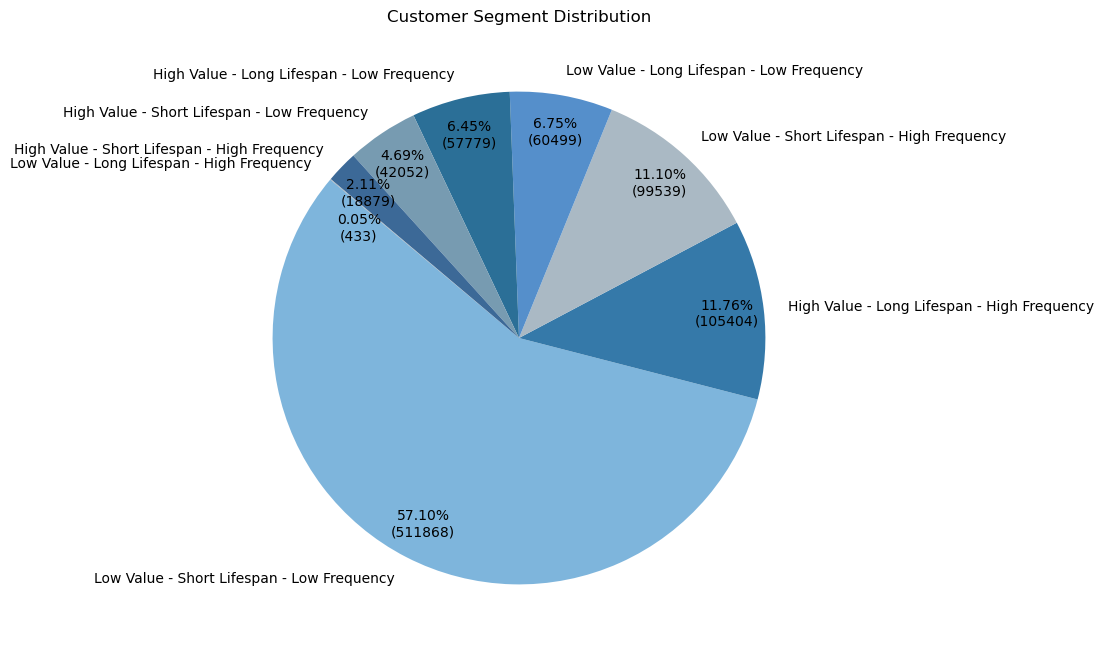

In [20]:
import matplotlib.pyplot as plt
segment_counts = hotel_features_up_to_2021['Customer_Segment'].value_counts()

colors = [
    '#7EB5DC',  
    '#3579A9',  
    '#AAB9C4',  
    '#558FCB', 
    '#2B6F97',  
    '#779BB1',  
    '#3C6997', 
    '#9DACB9'   
]
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val) if pct > 0 else ''
    return my_format

# Plotting the pie chart without explode
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(segment_counts, labels=segment_counts.index, autopct=autopct_format(segment_counts), 
        startangle=140, colors=colors, pctdistance=0.85, shadow=False)

# Adding title
plt.title('Customer Segment Distribution')

# Find the index of 'Low Value - Long Lifespan - High Frequency' segment
segment_label = 'Low Value - Long Lifespan - High Frequency'
for i, segment in enumerate(segment_counts.index):
    if segment == segment_label:
        autotexts[i].set_position((autotexts[i].get_position()[0], autotexts[i].get_position()[1] - 0.1))
        break

plt.show()